In [422]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf().setAppName("MyApp").setMaster("local[*]")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [423]:
!pip install pyspark==3.5.6
!pip install matplotlib
!pip install seaborn
!pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Setting up Imports and Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
from pyspark.sql.functions import col, from_json
import numpy as np
from pyspark.sql.types import *

def load_kaggle_json(dataset_id, target_filename=None):
    """
    Download, extract if needed, and load JSON from Kaggle dataset
    """
    import kagglehub
    import os
    import zipfile
    
    # Download
    path = kagglehub.dataset_download(dataset_id, force_download=True)
    
    # Extract zips
    for f in os.listdir(path):
        if f.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(path, f), 'r') as z:
                z.extractall(path)
    
    # Find JSON files
    json_files = []
    for root, dirs, files in os.walk(path):
        json_files.extend([os.path.join(root, f) for f in files if f.endswith('.json')])
    
    # Select file
    if target_filename:
        target_files = [f for f in json_files if target_filename in f]
        if target_files:
            return spark.read.json(target_files[0])
    
    if json_files:
        print(f"📄 Loading: {os.path.basename(json_files[0])}")
        return spark.read.json(json_files[0])
    
    raise FileNotFoundError("No JSON files found")

# Usage
df = load_kaggle_json("jinquan/cc-sample-data", "cc_sample_transaction.json")
df.printSchema()
df.show()

### Casting personal details & address to StringType for simplicity in data manipulation

In [425]:
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

In [426]:
df_flattened = df.select(
    "*",
    
    # Parse and flatten personal_detail in one go
    from_json(col("personal_detail"), personal_detail_schema).alias("personal_detail_parsed")
).select(
    "*",
    
    # Flattened personal detail fields
    col("personal_detail_parsed.person_name").alias("person_name"),
    col("personal_detail_parsed.gender").alias("gender"),
    col("personal_detail_parsed.lat").alias("person_lat"),
    col("personal_detail_parsed.long").alias("person_long"),
    col("personal_detail_parsed.city_pop").alias("city_pop"),
    col("personal_detail_parsed.job").alias("job"),
    col("personal_detail_parsed.dob").alias("dob"),
    
    # Parse nested address
    from_json(col("personal_detail_parsed.address"), address_schema).alias("address_parsed")
).select(
    "*",
    col("address_parsed.street").alias("street"),
    col("address_parsed.city").alias("city"),
    col("address_parsed.state").alias("state"),
    col("address_parsed.zip").alias("zip")
).drop("address_parsed", "personal_detail_parsed", "personal_detail")

df_flattened.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- person_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- person_lat: string (nullable = true)
 |-- person_long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: str

## Name Derivation

#### To better process names
#### 1. Remove all special characters except for hyphens, as these may be part of a name.
#### 2. Replace any multiple spaces with a single space. Once the names are clean, they can be split into an array of first and last names.

In [427]:
from pyspark.sql.functions import regexp_replace, split, trim, size, when
df_named_derived = df_flattened.withColumn(
    'cleaned_name',
    # Keep letters, hyphens and replace everything else with space
    regexp_replace(col('person_name'), r"[^A-Za-z\-']", ' ')
).withColumn(
    'cleaned_name',
    # Removing any Multiple spaces to single space
    regexp_replace(col('cleaned_name'), r'\s+', ' ')  
).withColumn(
    'cleaned_name',
    trim(col('cleaned_name'))
).withColumn(
    'name_array',
    split(col('cleaned_name'), ' ')
).withColumn(
    'first_name',
    when(size(col('name_array')) >= 1, col('name_array').getItem(0))
    .otherwise("Unknown")
).withColumn(
    'last_name',
    when(size(col('name_array')) >= 2, col('name_array').getItem(1))
    .otherwise("Unknown") 
).drop('cleaned_name', 'name_array')


In [428]:
# Rearranging columns
df_reordered = df_named_derived.select(
    'Unnamed: 0',
    'trans_date_trans_time',
    'cc_num',
    'merchant',
    'category',
    'amt',
    col('first_name').alias('first'),
    col('last_name').alias('last'),
    'gender',
    'street',
    'city',
    'state',
    'zip',
    col('person_lat').alias('lat'),
    col('person_long').alias('long'),
    'city_pop',
    'job',
    'dob',
    'trans_num',
    'merch_lat',
    'merch_long',
    'is_fraud',
    'merch_zipcode',
    'merch_last_update_time',
    'merch_eff_time',
    'cc_bic'
)

df_reordered.show()

+----------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+------------------+------------------+--------+-------------+----------------------+----------------+-----------+
|Unnamed: 0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num|         merch_lat|        merch_long|is_fraud|merch_zipcode|merch_last_update_time|  merch_eff_time|     cc_bic|
+----------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+

# Timestamp Conversation

### To standardize all datetime column into a yyyy-MM-dd HH:mm:ss with UTC timezone

In [429]:
from pyspark.sql.functions import date_format, expr, from_unixtime, col
df_with_timestamp = df_reordered.withColumn(
    'trans_date_trans_time',
    date_format(
        expr("to_timestamp(trans_date_trans_time, 'yyyy-MM-dd HH:mm:ss') + interval 8 hours"), # Adjust for timezone
        'yyyy-MM-dd HH:mm:ss'
    )
).withColumn(
    'merch_last_update_time',
    date_format(
        from_unixtime(col('merch_last_update_time').cast('bigint') / 1000 + 8*3600), # merch_last_update_time is in milliseconds
        'yyyy-MM-dd HH:mm:ss'
    )
).withColumn(
    'merch_eff_time', 
    date_format(
        from_unixtime(col('merch_eff_time').cast('bigint') / 1000000 + 8*3600), #merch_eff_time is in microseconds
        'yyyy-MM-dd HH:mm:ss'
    )
)
    

df_with_timestamp.show(truncate=False)

+----------+---------------------+-------------------+----------------------------------------+-------------+------+-----------+---------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+----------------------+-------------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num             |merchant                                |category     |amt   |first      |last     |gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |
+----------+---------------------+-------------------+----------------------------------

In [430]:
from pyspark.sql.functions import year, to_date, current_date, when, col
df_age = df_with_timestamp.withColumn(
    'age',
    year(current_date()) - year(to_date(col('dob'), 'yyyy-MM-dd'))
).withColumn(
        # For demographics: Keep generalized data
        'age_group',
        when(col('age') < 25, '18-24')
        .when(col('age') < 35, '25-34')
        .when(col('age') < 45, '35-44')
        .when(col('age') < 55, '45-54')
        .when(col('age') < 65, '55-64')
        .otherwise('65+')
)


df_age.show(10, truncate=False)

+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+------------------+--------+---------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+----------------------+-------------------+-----------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long              |city_pop|job                              |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |age|age_group|
+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+--

## Checks for Dirty Data

#### Standardize the Lat & Long coordinates into 4 decimal places

In [431]:
df_round_lat_long = df_age.withColumn(
    'lat',
    round(col('lat'), 4)
).withColumn(
    'long', 
    round(col('long'), 4)
).withColumn(
    'merch_lat',
    round(col('merch_lat'), 4)
).withColumn(
    'merch_long',
    round(col('merch_long'), 4)
)

df_round_lat_long.show(10000, truncate=False)

+----------+---------------------+-------------------+-------------------------------------------+--------------+-------+-----------+-----------+------+-----------------------------------+-------------------------+-----+-----+-------+---------+--------+-----------------------------------------------------------+----------+--------------------------------+---------+----------+--------+-------------+----------------------+-------------------+-----------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num             |merchant                                   |category      |amt    |first      |last       |gender|street                             |city                     |state|zip  |lat    |long     |city_pop|job                                                        |dob       |trans_num                       |merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |age|age_group|
+----------+---------------------+-------------------+----

#### Checking if the Boolean columns only have 2 values 

In [432]:
print("=== Checking Boolean columns values ===")
df_round_lat_long.select('gender').distinct().show()

df_round_lat_long.select('is_fraud').distinct().show()

=== Checking Boolean columns values ===


+------+
|gender|
+------+
|     F|
|     M|
+------+

+--------+
|is_fraud|
+--------+
|       0|
|       1|
+--------+



#### Sanity Checks if any of the customer is below age 18

In [433]:
print("Credit Card Age Eligibility")
df_round_lat_long.filter(col('age') < 18).show()

Credit Card Age Eligibility


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+



#### Sanity Checks for Column to only contain numeric values

In [434]:
from pyspark.sql.functions import regexp_extract, col
print("=== cc_num ===")
df_round_lat_long.filter(regexp_extract(col("cc_num"), "[a-zA-Z]", 0) != "").show()

print("=== ZipCode ===")
df_round_lat_long.filter(regexp_extract(col("zip"), "[a-zA-Z]", 0) != "").show()

print("=== Merch ZipCode ===")
df_round_lat_long.filter(regexp_extract(col("merch_zipcode"), "[a-zA-Z]", 0) != "").show()

print("=== City Population ===")
df_round_lat_long.filter(regexp_extract(col("city_pop"), "[a-zA-Z]", 0) != "").show()

print("Transaction Amount)")
df_round_lat_long.filter(regexp_extract(col("amt"), "[a-zA-Z]", 0) != "").show()

=== cc_num ===


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+

=== ZipCode ===


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+

=== Merch ZipCode ===


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+

=== City Population ===


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+

Transaction Amount)


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|age|age_group|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+---+---------+



# PII Protection Method

#### Masking all but the last four digits of a credit card number to protect sensitive data while still allowing for identification.

In [435]:
from pyspark.sql.functions import concat, lit, substring
df_masked = df_round_lat_long.withColumn(
    'cc_num_masked',
    concat(lit('****-****-****-'), substring(col('cc_num'), -4, 4))
)

df_masked.show(10, truncate=False)

+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+---------+----------+--------+-------------+----------------------+-------------------+-----------+---+---------+-------------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |age|age_group|cc_num_masked      |
+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+-------

#### Masking the first and last letter of the first name and the last name to protect sensitive data while also allowing of identification

In [436]:
from pyspark.sql.functions import length
df_practical_masked = df_masked.withColumn(
    'first_masked',
    when(length(col('first')) <= 2, 
         concat(substring(col('first'), 1, 1), lit('*')))
    .when(length(col('first')) <= 4,
         expr("concat(substring(first, 1, 1), repeat('*', length(first) - 2), substring(first, -1, 1))"))
    .otherwise(
         expr("concat(substring(first, 1, 2), repeat('*', length(first) - 3), substring(first, -1, 1))"))
).withColumn(
    'last_masked',
    when(length(col('last')) <= 2,
         concat(substring(col('last'), 1, 1), lit('*')))
    .when(length(col('last')) <= 4,
         expr("concat(substring(last, 1, 1), repeat('*', length(last) - 2), substring(last, -1, 1))"))
    .otherwise(
         expr("concat(substring(last, 1, 2), repeat('*', length(last) - 3), substring(last, -1, 1))"))
)

# Show original vs masked names
df_practical_masked.show(10, truncate=False)

+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+---------+----------+--------+-------------+----------------------+-------------------+-----------+---+---------+-------------------+------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |age|age_group|cc_num_masked      |first_masked|last_masked|
+----------+---------------------+----------------+----------------------------------+----

#### Hashing SHA256 is irreversible for person_name, cc_number to prevent any kind of data leak if theres any data breach incident

In [437]:
from pyspark.sql.functions import sha2
def apply_comprehensive_pii_protection(df):
    """
    Apply PII protection based on risk levels
    """
    return df.withColumn(
        'person_name_hash',
        sha2(concat(col('first'), lit('_'), col('last')), 256)
    ).withColumn(
        'dob_year_only',
        substring(col('dob'), 1, 4)  # Keep only birth year
    ).withColumn(
        'lat_area', round(col('lat'), 2)
    ).withColumn(
        'long_area', round(col('long'), 2)
    ).withColumn(
        'street_masked', lit('***REDACTED***')
    ).withColumn(
        'cc_hash', sha2(col('cc_num'), 256)
    )

df_insights_ready = apply_comprehensive_pii_protection(df_practical_masked)

df_insights_ready.show(10, truncate=False)

+----------+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+---------+----------+--------+-------------+----------------------+-------------------+-----------+---+---------+-------------------+------------+-----------+----------------------------------------------------------------+-------------+--------+---------+--------------+----------------------------------------------------------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merc

# Analysis

### Having a overview of the Data metrics

In [438]:
# Overall fraud statistics
total_transactions = df_insights_ready.count()
total_fraud_cases = df_insights_ready.filter(col('is_fraud') == 1).count()
overall_fraud_rate = (total_fraud_cases / total_transactions) * 100

print(f" DATASET OVERVIEW:")
print(f"   Total Transactions: {total_transactions:,}")
print(f"   Total Fraud Cases: {total_fraud_cases:,}")
print(f"   Overall Fraud Rate: {overall_fraud_rate:.3f}%")

# Fraud amount impact
total_amount = df_insights_ready.agg(sum('amt')).collect()[0][0]
fraud_amount = df_insights_ready.filter(col('is_fraud') == 1).agg(sum('amt')).collect()[0][0]
fraud_amount_rate = (fraud_amount / total_amount) * 100

print(f"   Total Transaction Volume: ${total_amount:,.2f}")
print(f"   Fraud Loss Amount: ${fraud_amount:,.2f}")
print(f"   Fraud Amount Rate: {fraud_amount_rate:.3f}%")

 DATASET OVERVIEW:
   Total Transactions: 1,296,675
   Total Fraud Cases: 7,506
   Overall Fraud Rate: 0.579%


   Total Transaction Volume: $91,222,428.90
   Fraud Loss Amount: $3,988,088.61
   Fraud Amount Rate: 4.372%


#### Having a idea on what are the distribution of transacted by Age Group & Gender

In [439]:
# Age distribution analysis
df_insights_ready.groupBy('age_group').count().orderBy('age_group').show()

# Gender and fraud correlation
df_insights_ready.groupBy('gender', 'is_fraud').count().show()

+---------+------+
|age_group| count|
+---------+------+
|    18-24| 19033|
|    25-34|187079|
|    35-44|299604|
|    45-54|302402|
|    55-64|197259|
|      65+|291298|
+---------+------+



+------+--------+------+
|gender|is_fraud| count|
+------+--------+------+
|     M|       1|  3771|
|     F|       1|  3735|
|     F|       0|706128|
|     M|       0|583041|
+------+--------+------+



#### Understanding the overall fraud rate by State level

In [440]:
# Transaction patterns by region
from pyspark.sql.functions import count, avg, sum, round
df_insights_ready.groupBy('state').agg(
    count('*').alias('transaction_count'),
    round(avg('amt'), 2).alias('avg_amount'),
    sum('is_fraud').cast('int').alias('fraud_cases'),
    round((sum(when(col('is_fraud') == 1, 1).otherwise(0)) / count('*') * 100),2).alias('fraud_rate')
).filter(col('transaction_count') > 100).orderBy(col('fraud_rate').desc()).show(50)

+-----+-----------------+----------+-----------+----------+
|state|transaction_count|avg_amount|fraud_cases|fraud_rate|
+-----+-----------------+----------+-----------+----------+
|   RI|              550|     81.94|         15|      2.73|
|   AK|             2120|     68.22|         36|       1.7|
|   NV|             5607|     56.54|         47|      0.84|
|   CO|            13880|     78.54|        113|      0.81|
|   OR|            18597|     70.42|        149|       0.8|
|   TN|            17554|     74.83|        140|       0.8|
|   NE|            24168|     67.24|        180|      0.74|
|   ME|            16505|     63.55|        119|      0.72|
|   NH|             8278|     74.01|         59|      0.71|
|   OH|            46480|     73.07|        321|      0.69|
|   VA|            29250|     70.73|        198|      0.68|
|   KS|            22996|     69.31|        156|      0.68|
|   SC|            29190|     64.32|        193|      0.66|
|   NY|            83501|     71.93|    

#### Understanding what catergories are the most exposes category to fraud

In [441]:
# Merchant category analysis
merchant_analysis = df_insights_ready.groupBy('category').agg(
    count('*').alias('total_transactions'),
    sum('is_fraud').cast('int').alias('fraud_count'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate'),
    round(avg('amt'), 2).alias('avg_amount')
).orderBy(col('fraud_rate').desc())

merchant_analysis.show(50, truncate=False)

+--------------+------------------+-----------+----------+----------+
|category      |total_transactions|fraud_count|fraud_rate|avg_amount|
+--------------+------------------+-----------+----------+----------+
|shopping_net  |97543             |1713       |1.76      |88.42     |
|misc_net      |63287             |915        |1.45      |80.87     |
|grocery_pos   |123638            |1743       |1.41      |116.96    |
|shopping_pos  |116672            |843        |0.72      |79.78     |
|gas_transport |131659            |618        |0.47      |63.43     |
|misc_pos      |79655             |250        |0.31      |62.89     |
|travel        |40507             |116        |0.29      |111.5     |
|grocery_net   |45452             |134        |0.29      |53.67     |
|entertainment |94014             |233        |0.25      |64.21     |
|personal_care |90758             |220        |0.24      |47.97     |
|kids_pets     |113035            |239        |0.21      |57.54     |
|food_dining   |9146

#### Which age group are the most susceptible to fraud 

In [442]:
#Fraud patterns by age group with proper ordering
fraud_by_age = df_insights_ready.withColumn(
    'age_order',  # Add sorting column
    when(col('age_group') == '18-24', 1)
    .when(col('age_group') == '25-34', 2)
    .when(col('age_group') == '35-44', 3)
    .when(col('age_group') == '45-54', 4)
    .when(col('age_group') == '55-64', 5)
    .when(col('age_group') == '65+', 6)
    .otherwise(7)
).groupBy('age_group', 'age_order').agg(
    count('*').alias('total_transactions'),
    sum('is_fraud').cast('int').alias('fraud_cases'),
    round((sum('is_fraud') / count('*') * 100), 4).alias('fraud_rate')
).orderBy('age_order').select(
    'age_group', 'total_transactions', 'fraud_cases', 'fraud_rate'
)

print("Fraud Rate by Age Group (Ascending Order):")
fraud_by_age.show()

Fraud Rate by Age Group (Ascending Order):


+---------+------------------+-----------+----------+
|age_group|total_transactions|fraud_cases|fraud_rate|
+---------+------------------+-----------+----------+
|    18-24|             19033|        118|      0.62|
|    25-34|            187079|       1133|    0.6056|
|    35-44|            299604|       1334|    0.4453|
|    45-54|            302402|       1310|    0.4332|
|    55-64|            197259|       1466|    0.7432|
|      65+|            291298|       2145|    0.7364|
+---------+------------------+-----------+----------+



#### Breakdown of Career Most suspectible for Fraud Transactions

In [443]:
# Transaction patterns by job type
job_analysis = df_insights_ready.groupBy('job').agg(
    count('*').alias('transactions'),
    sum('is_fraud').alias('fraud_cases'),
    round(avg('amt'), 2).alias('avg_amount'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate')
).filter(col('transactions') >= 20)  # Jobs with sufficient data

print("FRAUD RATE BY PROFESSION")
job_analysis.orderBy(col('fraud_rate').desc()).show(20)

# Gender-based analysis
gender_analysis = df_insights_ready.groupBy('gender').agg(
    count('*').alias('transactions'),
    sum('is_fraud').alias('fraud_cases'),
    round(avg('amt'), 2).alias('avg_amount'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate')
)

print("FRAUD PATTERNS BY GENDER")
gender_analysis.show()

FRAUD RATE BY PROFESSION


+--------------------+------------+-----------+----------+----------+
|                 job|transactions|fraud_cases|avg_amount|fraud_rate|
+--------------------+------------+-----------+----------+----------+
|              Lawyer|         540|       28.0|     87.22|      5.19|
|        TEFL teacher|         533|       22.0|     74.35|      4.13|
|Community develop...|         536|       22.0|    101.41|       4.1|
|Clinical cytogene...|         508|       18.0|     66.62|      3.54|
|              Writer|         504|       15.0|     92.48|      2.98|
|Geneticist, molec...|         545|       16.0|     92.46|      2.94|
|Conservator, muse...|         514|       15.0|     72.87|      2.92|
| Magazine journalist|         533|       14.0|      77.4|      2.63|
|Field trials officer|         518|       13.0|     94.71|      2.51|
|Civil Service adm...|         506|       12.0|     91.54|      2.37|
|Medical technical...|        1066|       25.0|     72.42|      2.35|
|     Charity office

+------+------------+-----------+----------+----------+
|gender|transactions|fraud_cases|avg_amount|fraud_rate|
+------+------------+-----------+----------+----------+
|     F|      709863|     3735.0|      70.2|      0.53|
|     M|      586812|     3771.0|     70.53|      0.64|
+------+------------+-----------+----------+----------+



#### Breakdown of Fraud Rate per State and Average Amount transacted

In [444]:
# Transaction patterns by region
from pyspark.sql.functions import count, avg, sum, when, col, round

state_analysis = df_insights_ready.groupBy('state').agg(
    count('*').alias('transaction_count'),
    round(avg('amt'),2).alias('avg_amount'),
    sum(when(col('is_fraud') == 1, 1).otherwise(0)).alias('fraud_cases'),
    round((sum(when(col('is_fraud') == 1, 1).otherwise(0)) / count('*') * 100), 2).alias('fraud_rate'),
    round(sum('amt'),2).alias('total_amount')
).filter(col('transaction_count') > 100 ).orderBy(col('fraud_rate').desc())

state_analysis.show(20, truncate=False)

# Show states with highest fraud rates
print("\n TOP 10 STATES BY FRAUD RATE")
state_analysis.filter(col('transaction_count') > 100) \
    .orderBy(col('fraud_rate').desc()) \
    .limit(10).show()

+-----+-----------------+----------+-----------+----------+------------+
|state|transaction_count|avg_amount|fraud_cases|fraud_rate|total_amount|
+-----+-----------------+----------+-----------+----------+------------+
|RI   |550              |81.94     |15         |2.73      |45066.67    |
|AK   |2120             |68.22     |36         |1.7       |144623.05   |
|NV   |5607             |56.54     |47         |0.84      |317000.03   |
|CO   |13880            |78.54     |113        |0.81      |1090171.31  |
|OR   |18597            |70.42     |149        |0.8       |1309575.16  |
|TN   |17554            |74.83     |140        |0.8       |1313513.23  |
|NE   |24168            |67.24     |180        |0.74      |1625146.83  |
|ME   |16505            |63.55     |119        |0.72      |1048856.74  |
|NH   |8278             |74.01     |59         |0.71      |612651.91   |
|OH   |46480            |73.07     |321        |0.69      |3396146.66  |
|VA   |29250            |70.73     |198        |0.6

+-----+-----------------+----------+-----------+----------+------------+
|state|transaction_count|avg_amount|fraud_cases|fraud_rate|total_amount|
+-----+-----------------+----------+-----------+----------+------------+
|   RI|              550|     81.94|         15|      2.73|    45066.67|
|   AK|             2120|     68.22|         36|       1.7|   144623.05|
|   NV|             5607|     56.54|         47|      0.84|   317000.03|
|   CO|            13880|     78.54|        113|      0.81|  1090171.31|
|   OR|            18597|     70.42|        149|       0.8|  1309575.16|
|   TN|            17554|     74.83|        140|       0.8|  1313513.23|
|   NE|            24168|     67.24|        180|      0.74|  1625146.83|
|   ME|            16505|     63.55|        119|      0.72|  1048856.74|
|   NH|             8278|     74.01|         59|      0.71|   612651.91|
|   OH|            46480|     73.07|        321|      0.69|  3396146.66|
+-----+-----------------+----------+-----------+---

#### Benchmark the fraud rate by state and category to create a standardized baseline for unbiased analysis

In [445]:
import numpy as np

def calculate_statistical_thresholds():
    """
    Calculate more appropriate statistical thresholds for fraud rate analysis
    """
    # Get fraud rates by different dimensions
    state_fraud_rates = state_analysis.select('fraud_rate').rdd.map(lambda x: x[0]).collect()
    category_fraud_rates = merchant_analysis.select('fraud_rate').rdd.map(lambda x: x[0]).collect()
    
    # Calculate statistical measures
    fraud_rates_combined = state_fraud_rates + category_fraud_rates
    
    mean_fraud_rate = np.mean(fraud_rates_combined)
    median_fraud_rate = np.median(fraud_rates_combined)
    std_fraud_rate = np.std(fraud_rates_combined)
    
    p25 = np.percentile(fraud_rates_combined, 25)  # 25th percentile
    p75 = np.percentile(fraud_rates_combined, 75)  # 75th percentile
    p90 = np.percentile(fraud_rates_combined, 90)  # 90th percentile
    
    print(" IMPROVED STATISTICAL FRAUD RATE THRESHOLDS:")
    print(f"   Mean Fraud Rate: {mean_fraud_rate:.3f}%")
    print(f"   Median Fraud Rate: {median_fraud_rate:.3f}%")
    print(f"   Standard Deviation: {std_fraud_rate:.3f}%")
    print(f"   25th Percentile: {p25:.3f}%")
    print(f"   75th Percentile: {p75:.3f}%")
    print(f"   90th Percentile: {p90:.3f}%")
    
    print(f"\n PERCENTILE-BASED THRESHOLDS")
    print(f" Low Risk: < {p25:.2f}% (Below 25th percentile)")
    print(f" Medium Risk: {p25:.2f}% - {p75:.2f}% (25th-75th percentile)")
    print(f" High Risk: {p75:.2f}% - {p90:.2f}% (75th-90th percentile)")
    print(f" Very High Risk: > {p90:.2f}% (Above 90th percentile)")
    
    return {
        'percentile_low': f"{p25:.3f}",
        'percentile_medium': f"{p75:.3f}",
        'percentile_high': f"{p90:.3f}",
        'mean': mean_fraud_rate,
        'median': median_fraud_rate
    }

improved_thresholds = calculate_statistical_thresholds()

 IMPROVED STATISTICAL FRAUD RATE THRESHOLDS:
   Mean Fraud Rate: 0.613%
   Median Fraud Rate: 0.560%
   Standard Deviation: 0.411%
   25th Percentile: 0.460%
   75th Percentile: 0.665%
   90th Percentile: 0.807%

 PERCENTILE-BASED THRESHOLDS
 Low Risk: < 0.46% (Below 25th percentile)
 Medium Risk: 0.46% - 0.67% (25th-75th percentile)
 High Risk: 0.67% - 0.81% (75th-90th percentile)
 Very High Risk: > 0.81% (Above 90th percentile)


## Visualization

In [446]:
# Configure matplotlib for better display
plt.style.use('default')
sns.set_palette("husl")

#### Preparing the dataframe into Pandas for Visualization

In [447]:
# Convert key analyses to Pandas for plotting
fraud_by_age_pd = fraud_by_age.toPandas()
state_analysis_pd = state_analysis.limit(15).toPandas()  # Top 15 states
merchant_analysis_pd = merchant_analysis.toPandas()

####  Most susceptible High Risk Merchant Categories with Fraud_rate > 75th Percentile

In [448]:
#High-risk merchant categories
high_risk_merchants = high_risk_merchants = df_insights_ready.groupBy('category').agg(
    round(avg('amt'),2).alias('avg_amount'),
    (sum('is_fraud') / count('*') * 100).alias('fraud_rate')
).filter(col('fraud_rate') > improved_thresholds['percentile_medium']).orderBy(col('fraud_rate').desc())

print("High-Risk Merchant Categories:")
high_risk_merchants.show()

High-Risk Merchant Categories:


+------------+----------+------------------+
|    category|avg_amount|        fraud_rate|
+------------+----------+------------------+
|shopping_net|     88.42|1.7561485703740916|
|    misc_net|     80.87|1.4457945549638946|
| grocery_pos|    116.96|1.4097607531665022|
|shopping_pos|     79.78|0.7225383982446517|
+------------+----------+------------------+



#### Breakdown of Hour of Most suspectible of Fraud Merchant Category

FRAUD PATTERNS BY HOUR


+----+------------+-----------+----------+
|hour|transactions|fraud_cases|fraud_rate|
+----+------------+-----------+----------+
|   0|       65726|       76.0|      0.12|
|   1|       65450|       78.0|      0.12|
|   2|       66051|       81.0|      0.12|
|   3|       65508|       81.0|      0.12|
|   4|       65098|       62.0|       0.1|
|   5|       65533|       74.0|      0.11|
|   6|       66982|     1931.0|      2.88|
|   7|       67104|     1904.0|      2.84|
|   8|       42502|      635.0|      1.49|
|   9|       42869|      658.0|      1.53|
|  10|       42656|      625.0|      1.47|
|  11|       42769|      609.0|      1.42|
|  12|       41863|       46.0|      0.11|
|  13|       42171|       60.0|      0.14|
|  14|       42300|       40.0|      0.09|
|  15|       42203|       56.0|      0.13|
|  16|       42505|       49.0|      0.12|
|  17|       42185|       47.0|      0.11|
|  18|       42271|       40.0|      0.09|
|  19|       42082|       42.0|       0.1|
|  20|     

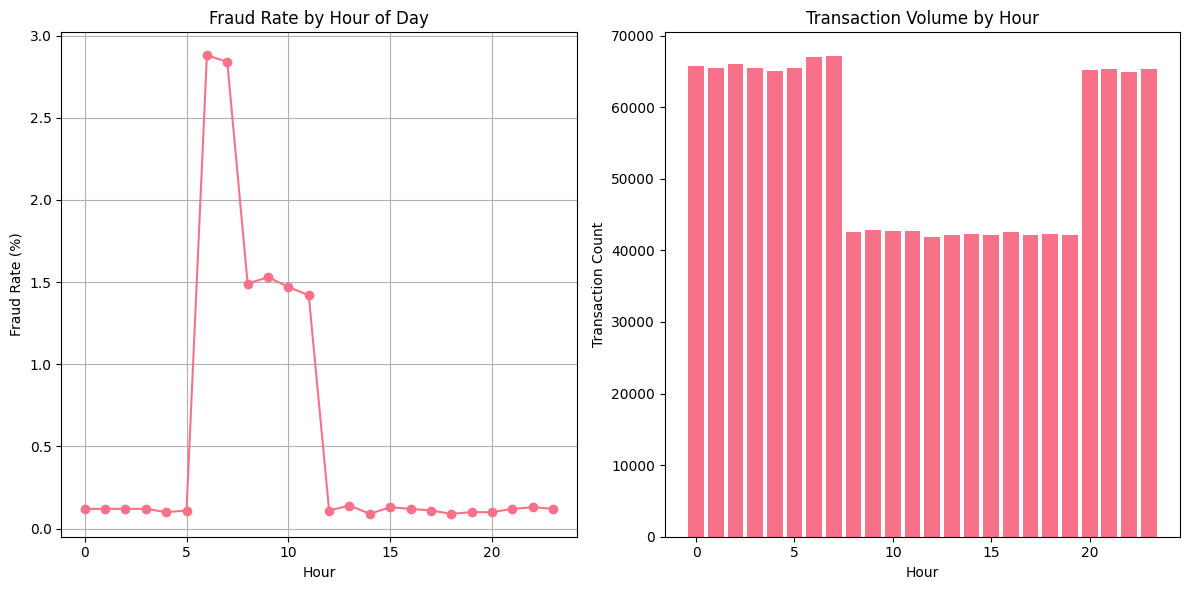

+----+------------+------------+-----------+----------+
|hour|    category|transactions|fraud_cases|fraud_rate|
+----+------------+------------+-----------+----------+
|   0|shopping_net|        4688|       20.0|      0.43|
|   1|shopping_net|        4682|       23.0|      0.49|
|   2|shopping_net|        4664|       27.0|      0.58|
|   3|shopping_net|        4597|       28.0|      0.61|
|   4|shopping_net|        4422|       22.0|       0.5|
|   5|shopping_net|        4441|       21.0|      0.47|
|   6|    misc_net|        1190|      281.0|     23.61|
|   7|    misc_net|        1194|      314.0|      26.3|
|   8| grocery_pos|       10114|      305.0|      3.02|
|   9| grocery_pos|       10323|      315.0|      3.05|
|  10| grocery_pos|       10346|      297.0|      2.87|
|  11| grocery_pos|       10408|      302.0|       2.9|
|  12| grocery_pos|        9952|       23.0|      0.23|
|  13| grocery_pos|       10086|       30.0|       0.3|
|  14| grocery_pos|        9950|       21.0|    

In [449]:
from pyspark.sql.functions import hour, dayofweek, month, row_number, desc
from pyspark.sql.window import Window


# Extract time components for analysis
time_analysis = df_insights_ready.withColumn(
    'hour', hour(col('trans_date_trans_time')).cast('int')
).withColumn(
    'day_of_week', dayofweek(col('trans_date_trans_time'))
).withColumn(
    'month', month(col('trans_date_trans_time'))
)

# Fraud by hour of day
fraud_by_hour = time_analysis.groupBy('hour').agg(
    count('*').alias('transactions'),
    sum('is_fraud').alias('fraud_cases'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate')
).orderBy('hour')

merchant_by_hour = time_analysis.groupBy('hour', 'category').agg(
    count('*').alias('transactions'),
    sum('is_fraud').alias('fraud_cases'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate')
).filter(col('transactions') >= 1000) # At least 1000 transactions for meaningful analysis

# Define window to rank categories by fraud rate within each hour
window_spec = Window.partitionBy('hour').orderBy(desc('fraud_rate'))

# Get the category with highest fraud rate for each hour
highest_fraud_category_by_hour = merchant_by_hour.withColumn(
    'rank', row_number().over(window_spec)
).filter(col('rank') == 1).select(
    'hour',
    'category',
    'transactions',
    'fraud_cases',
    'fraud_rate'
).orderBy('hour')

print("FRAUD PATTERNS BY HOUR")
fraud_by_hour.show(24)


# Convert to pandas and visualize
fraud_by_hour_pd = fraud_by_hour.toPandas()
merchant_by_hour_pd = highest_fraud_category_by_hour.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fraud_by_hour_pd['hour'], fraud_by_hour_pd['fraud_rate'], marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(fraud_by_hour_pd['hour'], fraud_by_hour_pd['transactions'])
plt.title('Transaction Volume by Hour')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

highest_fraud_category_by_hour.show(24)

#### Coorelation between Amount & Fraud rate

In [450]:
# By transaction amount with custom ordering
amount_analysis = df_insights_ready.withColumn(
    'amount_tier',
    when(col('amt') < 50, 'Small (<$50)')
    .when(col('amt') < 200, 'Medium ($50-$200)')
    .when(col('amt') < 500, 'Large ($200-$500)')
    .otherwise('Very Large (>$500)')
).withColumn(
    'tier_order',  # Add sorting column
    when(col('amt') < 50, 1)
    .when(col('amt') < 200, 2)
    .when(col('amt') < 500, 3)
    .otherwise(4)
).groupBy('amount_tier', 'tier_order').agg(
    count('*').alias('transactions'),
    round(sum('is_fraud').cast('int')).alias('fraud_cases'),
    round((sum('is_fraud') / count('*') * 100), 3).alias('fraud_rate')
).orderBy('tier_order').select(
    'amount_tier', 'transactions', 'fraud_cases', 'fraud_rate'
)

print("FRAUD RATE BY TRANSACTION AMOUNT (ASCENDING ORDER):")
amount_analysis.show()

FRAUD RATE BY TRANSACTION AMOUNT (ASCENDING ORDER):


+------------------+------------+-----------+----------+
|       amount_tier|transactions|fraud_cases|fraud_rate|
+------------------+------------+-----------+----------+
|      Small (<$50)|      672214|       1607|     0.239|
| Medium ($50-$200)|      562531|        195|     0.035|
| Large ($200-$500)|       46299|       2056|     4.441|
|Very Large (>$500)|       15631|       3648|    23.338|
+------------------+------------+-----------+----------+



#### The analysis will be visually represented through plots of the fraud rate by age group, a comparison of the top 10 states and merchant categories by fraud rate, and an examination of transaction amount against fraud rate.

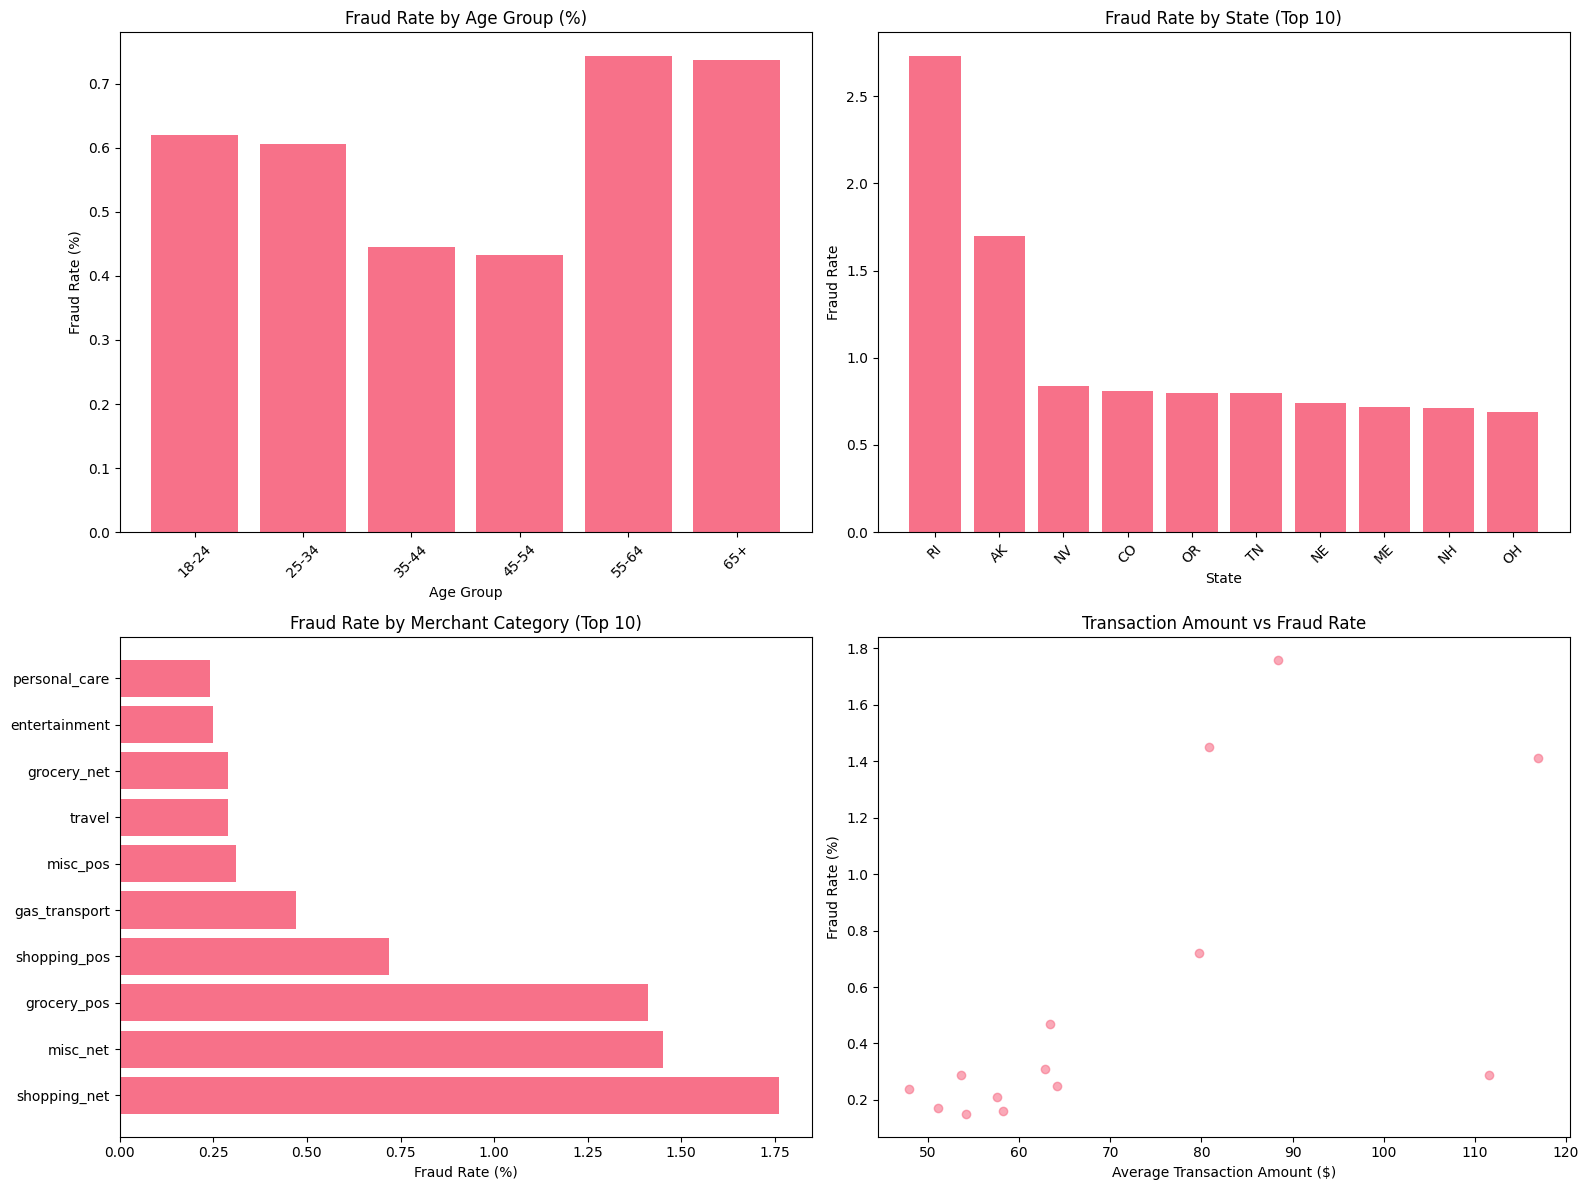

In [451]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fraud Rate by Age Group
axes[0,0].bar(fraud_by_age_pd['age_group'], fraud_by_age_pd['fraud_rate'])
axes[0,0].set_title('Fraud Rate by Age Group (%)')
axes[0,0].set_xlabel('Age Group')
axes[0,0].set_ylabel('Fraud Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Fraud Rate by State (Top 10)
top_states = state_analysis_pd.head(10)
axes[0,1].bar(top_states['state'], top_states['fraud_rate'])
axes[0,1].set_title('Fraud Rate by State (Top 10)')
axes[0,1].set_xlabel('State')
axes[0,1].set_ylabel('Fraud Rate')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Fraud Rate by Merchant Category (Top 10)
top_merchants = merchant_analysis_pd.head(10)
axes[1,0].barh(top_merchants['category'], top_merchants['fraud_rate'])
axes[1,0].set_title('Fraud Rate by Merchant Category (Top 10)')
axes[1,0].set_xlabel('Fraud Rate (%)')

# 4. Average Transaction Amount vs Fraud Rate
axes[1,1].scatter(merchant_analysis_pd['avg_amount'], merchant_analysis_pd['fraud_rate'], alpha=0.6)
axes[1,1].set_title('Transaction Amount vs Fraud Rate')
axes[1,1].set_xlabel('Average Transaction Amount ($)')
axes[1,1].set_ylabel('Fraud Rate (%)')

plt.tight_layout()
plt.show()

#### Breakdown to city level

In [452]:
# Create geographic insights
geographic_analysis = df_insights_ready.groupBy('state', 'city', 'zip').agg(
    count('*').alias('transactions'),
    sum('is_fraud').cast('int').alias('fraud_cases'),
    round(avg('amt'), 2).alias('avg_amount'),
    round((sum('is_fraud') / count('*') * 100), 2).alias('fraud_rate')
).filter(col('transactions') >= 100)


# High-risk cities
high_risk_cities = geographic_analysis.filter(col('fraud_rate') > improved_thresholds['percentile_high']).orderBy(col('fraud_rate').desc())
print(f"HIGH-RISK CITIES (> {improved_thresholds['percentile_high']}% fraud rate)")
high_risk_cities.show()

HIGH-RISK CITIES (> 0.807% fraud rate)


+-----+--------------------+-----+------------+-----------+----------+----------+
|state|                city|  zip|transactions|fraud_cases|avg_amount|fraud_rate|
+-----+--------------------+-----+------------+-----------+----------+----------+
|   IA|              Moscow|52760|         516|         16|     65.85|       3.1|
|   MT|             Boulder|59632|         493|         15|     72.78|      3.04|
|   MI|           Riverview|48193|         504|         15|     92.48|      2.98|
|   NY|          Howes Cave|12092|         504|         15|     70.99|      2.98|
|   FL|          Clearwater|33760|         545|         16|     92.46|      2.94|
|   OR|            Bay City|97107|         511|         15|      63.2|      2.94|
|   GA|              Girard|30426|         514|         15|     72.87|      2.92|
|   WV|White Sulphur Spr...|24986|         529|         15|     95.95|      2.84|
|   MS|         Pearlington|39572|         529|         15|     70.29|      2.84|
|   NY|         

# Getting Additional Datasets

In [453]:
# Create a function to map state names to abbreviations
state_abbreviation_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK', 
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Los Angeles County': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'New York city': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


def add_state_abbreviations(df):
    items = list(state_abbreviation_mapping.items())
    first_state, first_abbrev = items[0]
    
    # Initialize the when expression
    state_mapping_expr = when(col('State') == first_state, first_abbrev)
    
    # Chain all other conditions
    for state_name, abbrev in items[1:]:
        state_mapping_expr = state_mapping_expr.when(col('State') == state_name, abbrev)
    
    # Add the column with default value
    return df.withColumn('state_abbrev', state_mapping_expr.otherwise('Unknown'))

In [ ]:
path = kagglehub.dataset_download("justin2028/unemployment-in-america-per-us-state")

### Unemployment in US per State Datasets

In [477]:
#https://www.kaggle.com/datasets/justin2028/unemployment-in-america-per-us-state

unemployment = spark.read.csv(
    '/Users/user/Repository/cdx-datahub-aml/Unemployment.csv',
    header=True,
    inferSchema=True
)

unemployment_with_abbrev = add_state_abbreviations(unemployment)

# Calculate average unemployment rate by state from 2018 to 2022 for more recent data
recent_unemployment = unemployment_with_abbrev.filter(
    (col('Year') >= 2018) & (col('Year') <= 2022)
).groupBy('state_abbrev').agg(
    # Use median instead of mean for better central tendency
    expr("percentile_approx(`Percent (%) of Labor Force Unemployed in State/Area`, 0.5)").alias('median_unemployment_rate'),
    round(avg(col('Percent (%) of Labor Force Unemployed in State/Area')),2).alias('mean_unemployment_rate')
).orderBy('median_unemployment_rate')

print("TOP 10 STATES WITH HIGHEST Median UNEMPLOYMENT")
recent_unemployment.orderBy(col('mean_unemployment_rate').desc()).limit(10).show()

print("TOP 10 STATES WITH LOWEST Median UNEMPLOYMENT")
recent_unemployment.orderBy(col('mean_unemployment_rate').asc()).limit(10).show()


TOP 10 STATES WITH HIGHEST Median UNEMPLOYMENT
+------------+------------------------+----------------------+
|state_abbrev|median_unemployment_rate|mean_unemployment_rate|
+------------+------------------------+----------------------+
|          NV|                     5.3|                   6.9|
|          CA|                     4.7|                  6.54|
|          NY|                     4.3|                  6.52|
|          DC|                     5.7|                   6.1|
|          AK|                     5.9|                  6.08|
|          NM|                     5.1|                  5.78|
|          IL|                     4.6|                  5.67|
|          MI|                     4.2|                  5.66|
|          PA|                     4.4|                  5.61|
|          MS|                     5.4|                  5.59|
+------------+------------------------+----------------------+

TOP 10 STATES WITH LOWEST Median UNEMPLOYMENT
+------------+----------

#### Fraud Rate vs Unemployment Rate by State

In [455]:
# Join unemployment data with your state fraud analysis
fraud_unemployment_analysis = state_analysis.join(
    recent_unemployment,
    state_analysis.state == recent_unemployment.state_abbrev,
    'left'
).select(
    state_analysis['*'],
    recent_unemployment['state_abbrev'].alias('state_name'),
    recent_unemployment['median_unemployment_rate'],
    recent_unemployment['mean_unemployment_rate'],
).filter(col('transaction_count') > 100)

fraud_unemployment_analysis.select(
    'state',
    'fraud_rate',
    'median_unemployment_rate',
    'mean_unemployment_rate'
).orderBy(col('median_unemployment_rate').desc()).show(50, truncate=False)

+-----+----------+------------------------+----------------------+
|state|fraud_rate|median_unemployment_rate|mean_unemployment_rate|
+-----+----------+------------------------+----------------------+
|AK   |1.7       |5.9                     |6.08                  |
|DC   |0.58      |5.7                     |6.1                   |
|MS   |0.54      |5.4                     |5.59                  |
|NV   |0.84      |5.3                     |6.9                   |
|NM   |0.5       |5.1                     |5.78                  |
|WV   |0.57      |5.1                     |5.48                  |
|AZ   |0.34      |4.8                     |5.27                  |
|LA   |0.43      |4.8                     |5.47                  |
|CA   |0.58      |4.7                     |6.54                  |
|IL   |0.57      |4.6                     |5.67                  |
|WA   |0.51      |4.5                     |5.3                   |
|OH   |0.69      |4.4                     |5.23               

#### Correlation between Fraud Rate and Unemployment

In [456]:
# Convert to pandas for correlation analysis
fraud_unemployment_pd = fraud_unemployment_analysis.select(
    'fraud_rate',
    'median_unemployment_rate',
    'mean_unemployment_rate'
).filter(
    col('fraud_rate').isNotNull() & 
    col('median_unemployment_rate').isNotNull() &
    col('mean_unemployment_rate').isNotNull()
).toPandas()

# Calculate correlations
median_correlation = fraud_unemployment_pd['fraud_rate'].corr(
    fraud_unemployment_pd['median_unemployment_rate']
)
mean_correlation = fraud_unemployment_pd['fraud_rate'].corr(
    fraud_unemployment_pd['mean_unemployment_rate']
)

#### There is a positive correlation of 0.161 between a state's median unemployment rate and its fraud rate. This trend is also consistent with the relationship observed using the mean unemployment rate with positive correlation of 0.149

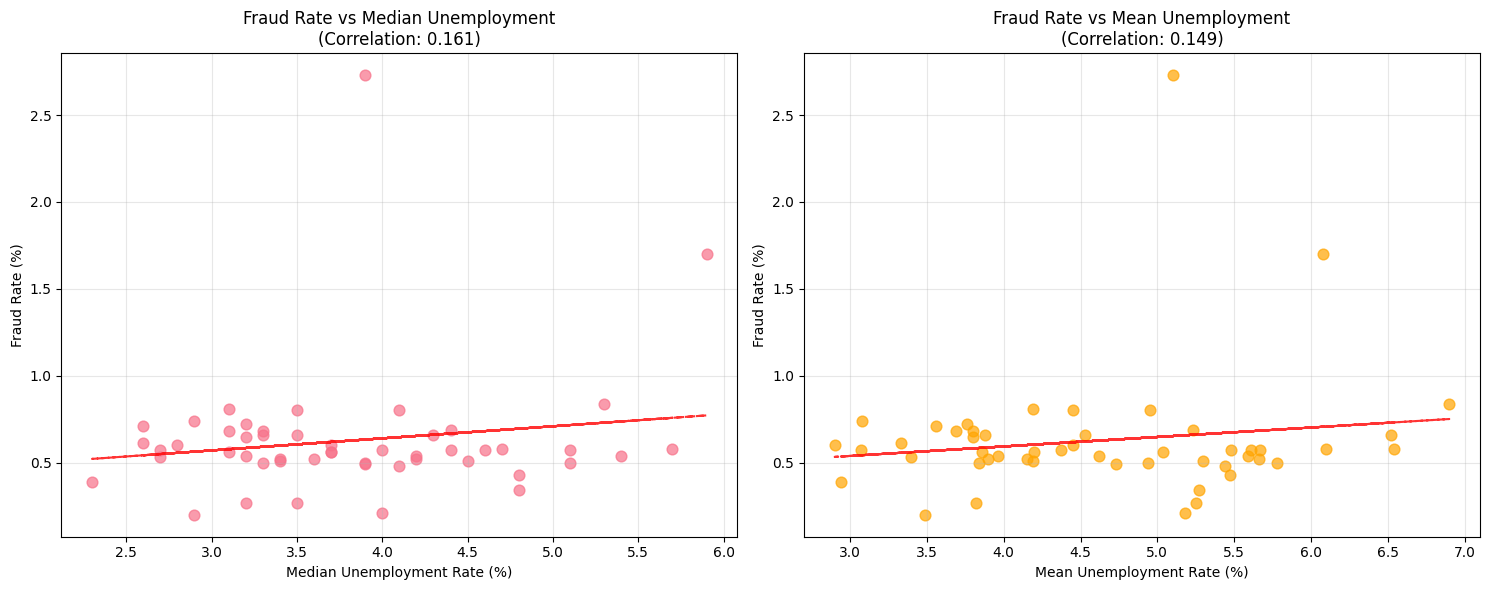

In [457]:
# Create scatter plots to visualize the relationships
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Fraud Rate vs Median Unemployment
axes[0].scatter(fraud_unemployment_pd['median_unemployment_rate'], 
               fraud_unemployment_pd['fraud_rate'], 
               alpha=0.7, s=60)
axes[0].set_xlabel('Median Unemployment Rate (%)')
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].set_title(f'Fraud Rate vs Median Unemployment\n(Correlation: {median_correlation:.3f})')
axes[0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(fraud_unemployment_pd['median_unemployment_rate'], 
               fraud_unemployment_pd['fraud_rate'], 1)
p = np.poly1d(z)
axes[0].plot(fraud_unemployment_pd['median_unemployment_rate'], 
             p(fraud_unemployment_pd['median_unemployment_rate']), 
             "r--", alpha=0.8)

# Fraud Rate vs Mean Unemployment
axes[1].scatter(fraud_unemployment_pd['mean_unemployment_rate'], 
               fraud_unemployment_pd['fraud_rate'], 
               alpha=0.7, s=60, color='orange')
axes[1].set_xlabel('Mean Unemployment Rate (%)')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].set_title(f'Fraud Rate vs Mean Unemployment\n(Correlation: {mean_correlation:.3f})')
axes[1].grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(fraud_unemployment_pd['mean_unemployment_rate'], 
                fraud_unemployment_pd['fraud_rate'], 1)
p2 = np.poly1d(z2)
axes[1].plot(fraud_unemployment_pd['mean_unemployment_rate'], 
             p2(fraud_unemployment_pd['mean_unemployment_rate']), 
             "r--", alpha=0.8)

plt.tight_layout()
plt.show()

### Cost of Living and Median Income Datasets

In [458]:
# https://www.kaggle.com/datasets/zacvaughan/cityzipcountyfips-quality-of-life

us_cities_qol = spark.read.csv(
    '/Users/user/Repository/cdx-datahub-aml/us_cities_qol.csv',
    header=True,
    inferSchema=True
)

us_cities_qol.show(5, truncate=False)

+----------------------+------+--------------------+-----+-----+-----------------+------------+---------------+---------------+------------+-------------------+-----------------+--------+---------------+------------------+------------+----------+-------------+--------------+------------------+-------+------+------+-------+-------+-------+------+-------+-------+-------+-------+------------+---------------------+-----------------------+
|countyhelper          |LSTATE|NMCNTY              |FIPS |LZIP |ULOCALE          |Overall Rank|2022 Population|2016 Crime Rate|Unemployment|2020PopulrVoteParty|2020 PopulrMajor%|AQI%Good|WaterQualityVPV|ParkScore2023 Rank|%CvgCityPark|NtnlPrkCnt|%CvgStatePark|Cost of Living|2022 Median Income|AVG C2I|1p0c  |1p1c  |1p2c   |1p3c   |1p4c   |2p0c  |2p1c   |2p2c   |2p3c   |2p4c   |Stu:Tea Rank|Diversity Rank (Race)|Diversity Rank (Gender)|
+----------------------+------+--------------------+-----+-----+-----------------+------------+---------------+-----------

#### Converting String data to Integer data

In [459]:
# Check for non-numeric values
us_cities_qol.filter(
    col('Cost of Living').rlike('[^0-9.]') | 
    col('Cost of Living').isNull() |
    (col('Cost of Living') == '') |
    col('2022 Median Income').rlike('[^0-9.]') | 
    col('2022 Median Income').isNull() |
    (col('2022 Median Income') == '')
).select('LSTATE', 'NMCNTY', 'Cost of Living', '2022 Median Income')



DataFrame[LSTATE: string, NMCNTY: string, Cost of Living: string, 2022 Median Income: string]

#### To more accurately assess affordability in different cities, our analysis will move beyond a simple comparison of Cost of Living and Median Income to account for variations in expenses and living wages across states.

In [460]:
# Clean and convert Cost of Living to numeric
us_cities_qol_cleaned = us_cities_qol.withColumn(
    'cost_of_living_numeric',
    regexp_replace(col('Cost of Living'), '[^0-9.]', '').cast('double')
).withColumn(
    'median_income_numeric',
    regexp_replace(col('2022 Median Income'), '[^0-9.]', '').cast('double')
).filter(
    # Keep rows with valid data for both metrics
    col('cost_of_living_numeric').isNotNull() & 
    (col('cost_of_living_numeric') > 0) &
    col('median_income_numeric').isNotNull() & 
    (col('median_income_numeric') > 0)
).withColumn(
    # Calculate affordability metrics
    'cost_to_income_ratio',
    round(col('cost_of_living_numeric') / col('median_income_numeric') * 100, 2)
).withColumn(
    'income_minus_cost',
    round(col('median_income_numeric') - col('cost_of_living_numeric'), 2)
).withColumn(
    # Create affordability categories
    'affordability_category',
    when(col('cost_to_income_ratio') > 30, 'High Cost Burden (>30%)')
    .when(col('cost_to_income_ratio') > 20, 'Medium Cost Burden (20-30%)')
    .otherwise('Low Cost Burden (<20%)')
)


us_cities_qol_cleaned.select(
    'LSTATE', 'NMCNTY', 
    'cost_of_living_numeric', 
    'median_income_numeric',
    'cost_to_income_ratio',
    'income_minus_cost',
    'affordability_category'
).orderBy(col('cost_to_income_ratio').desc()).show(20, truncate=False)

+------+--------------------+----------------------+---------------------+--------------------+-----------------+-----------------------+
|LSTATE|NMCNTY              |cost_of_living_numeric|median_income_numeric|cost_to_income_ratio|income_minus_cost|affordability_category |
+------+--------------------+----------------------+---------------------+--------------------+-----------------+-----------------------+
|SD    |Todd County         |73348.34              |25529.98             |287.3               |-47818.36        |High Cost Burden (>30%)|
|WV    |McDowell County     |77692.63              |32785.53             |236.97              |-44907.1         |High Cost Burden (>30%)|
|GA    |Clay County         |61159.3               |27326.92             |223.81              |-33832.38        |High Cost Burden (>30%)|
|NY    |Bronx County        |102815.48             |48566.82             |211.7               |-54248.66        |High Cost Burden (>30%)|
|SD    |Oglala Lakota County|70724

#### A more affordable city to live in, the lower the better. Which mean you are more likely to have extra income for disposal 

In [461]:
us_state_affordability = us_cities_qol_cleaned.groupBy('LSTATE').agg(
    # Cost of living metrics
    expr("percentile_approx(cost_of_living_numeric, 0.5)").alias('median_cost_of_living'),
    round(avg(col('cost_of_living_numeric')), 2).alias('mean_cost_of_living'),
    
    # Income metrics
    expr("percentile_approx(median_income_numeric, 0.5)").alias('median_income'),
    round(avg(col('median_income_numeric')), 2).alias('mean_income'),
    
    # Affordability metrics
    expr("percentile_approx(cost_to_income_ratio, 0.5)").alias('median_cost_to_income_ratio'),
    round(avg(col('cost_to_income_ratio')), 2).alias('mean_cost_to_income_ratio'),
    
    expr("percentile_approx(income_minus_cost, 0.5)").alias('median_income_minus_cost'),
    round(avg(col('income_minus_cost')), 2).alias('mean_income_minus_cost'),
    
    count('*').alias('cities_count')
).orderBy('median_cost_to_income_ratio')

print("STATE-LEVEL AFFORDABILITY ANALYSIS")
us_state_affordability.show(10, truncate=False)

STATE-LEVEL AFFORDABILITY ANALYSIS
+------+---------------------+-------------------+-------------+-----------+---------------------------+-------------------------+------------------------+----------------------+------------+
|LSTATE|median_cost_of_living|mean_cost_of_living|median_income|mean_income|median_cost_to_income_ratio|mean_cost_to_income_ratio|median_income_minus_cost|mean_income_minus_cost|cities_count|
+------+---------------------+-------------------+-------------+-----------+---------------------------+-------------------------+------------------------+----------------------+------------+
|ND    |66728.08             |68709.93           |83668.87     |82881.29   |81.17                      |84.94                    |15756.38                |14171.36              |53          |
|MD    |77471.59             |79001.49           |94147.63     |96138.13   |82.31                      |85.04                    |16676.04                |17136.64              |24          |
|RI  

#### Afforable vs Fraud Rate

In [462]:
fraud_affordability_analysis = state_analysis.join(
    us_state_affordability,
    state_analysis.state == us_state_affordability.LSTATE,
    'left'
).select(
    state_analysis['*'],
    us_state_affordability['median_cost_of_living'],
    us_state_affordability['median_income'],
    us_state_affordability['median_cost_to_income_ratio'],
    us_state_affordability['median_income_minus_cost'],
    us_state_affordability['mean_cost_to_income_ratio']
).filter(col('transaction_count') > 100)

print("FRAUD RATE vs AFFORDABILITY BY STATE")
fraud_affordability_analysis.select(
    'state',
    'fraud_rate',
    'median_cost_to_income_ratio',
    'median_income_minus_cost',
    'median_cost_of_living',
    'median_income'
).orderBy(col('fraud_rate').desc()).show(50, truncate=False)

FRAUD RATE vs AFFORDABILITY BY STATE


+-----+----------+---------------------------+------------------------+---------------------+-------------+
|state|fraud_rate|median_cost_to_income_ratio|median_income_minus_cost|median_cost_of_living|median_income|
+-----+----------+---------------------------+------------------------+---------------------+-------------+
|RI   |2.73      |83.61                      |15653.46                |83194.2              |106276.49    |
|AK   |1.7       |99.33                      |-968.57                 |86676.13             |85354.91     |
|NV   |0.84      |104.68                     |-3369.75                |75364.63             |73747.67     |
|CO   |0.81      |105.6                      |-4096.22                |71551.74             |67065.09     |
|OR   |0.8       |123.87                     |-16292.66               |83608.42             |65170.59     |
|TN   |0.8       |107.28                     |-4028.17                |61577.16             |57668.61     |
|NE   |0.74      |109.75    

#### Setting for visualization

In [463]:
# Convert to pandas for correlation analysis
fraud_affordability_pd = fraud_affordability_analysis.select(
    'fraud_rate',
    'median_cost_to_income_ratio',
    'median_income_minus_cost',
    'median_cost_of_living',
    'median_income'
).filter(
    col('fraud_rate').isNotNull() & 
    col('median_cost_to_income_ratio').isNotNull() &
    col('median_income_minus_cost').isNotNull() &
    col('median_cost_of_living').isNotNull() &
    col('median_income').isNotNull()
).toPandas()

# Calculate correlations
cost_ratio_correlation = fraud_affordability_pd['fraud_rate'].corr(
    fraud_affordability_pd['median_cost_to_income_ratio']
)
income_diff_correlation = fraud_affordability_pd['fraud_rate'].corr(
    fraud_affordability_pd['median_income_minus_cost']
)
cost_correlation = fraud_affordability_pd['fraud_rate'].corr(
    fraud_affordability_pd['median_cost_of_living']
)
income_correlation = fraud_affordability_pd['fraud_rate'].corr(
    fraud_affordability_pd['median_income']
)

##### Cost vs. Fraud: States with a higher cost-to-income ratio (less affordability) show a negative correlation with fraud. This suggests that areas with higher living expenses tend to have lower fraud rates, possibly due to more robust security systems and a more affluent population.

#### Disposable Income vs. Fraud: States with a higher amount of disposable income show a positive correlation with fraud. This indicates that where people have more money left over after expenses, fraud rates tend to be higher, likely because these individuals are more attractive targets for fraudsters.

#### Relative Affordability Matters: The analysis shows that raw numbers for cost of living and median income have a near-zero correlation with fraud. This means that relative affordability (how income compares to cost) is a much stronger indicator of fraud risk than absolute financial figures.

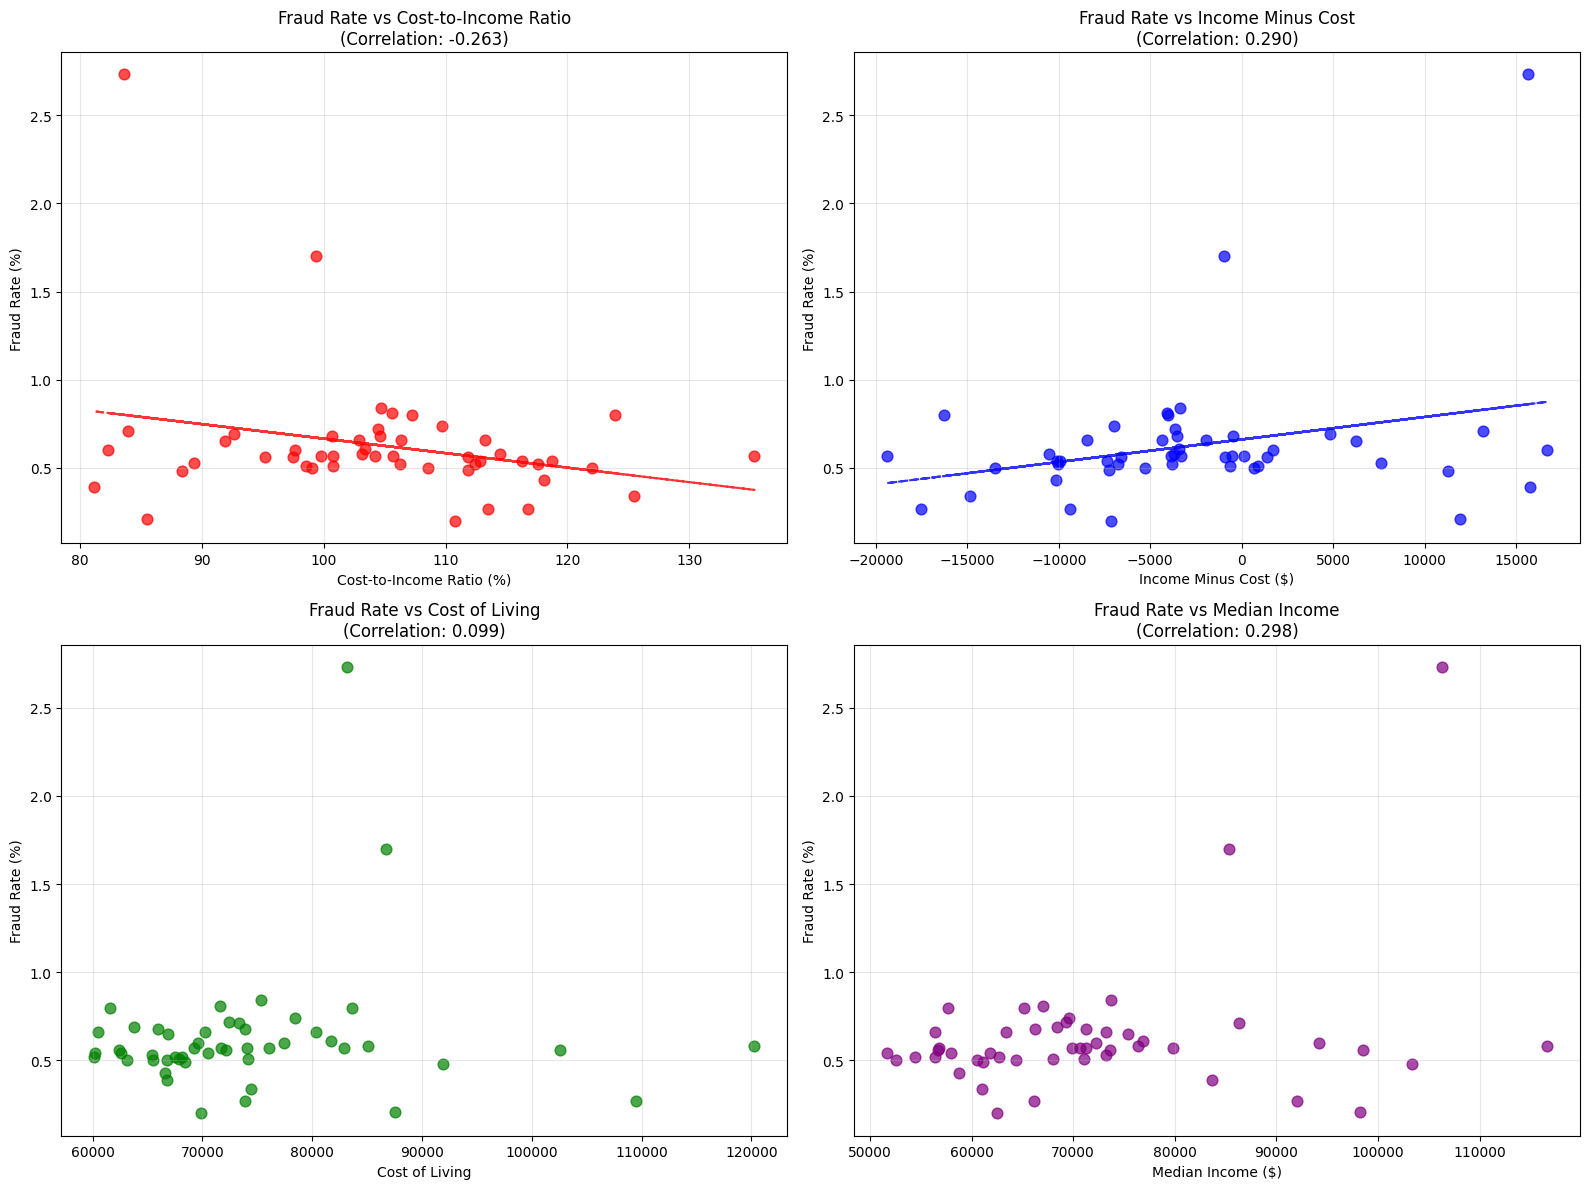

In [464]:
# Create comprehensive affordability visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fraud Rate vs Cost-to-Income Ratio
axes[0,0].scatter(fraud_affordability_pd['median_cost_to_income_ratio'], 
                 fraud_affordability_pd['fraud_rate'], 
                 alpha=0.7, s=60, color='red')
axes[0,0].set_xlabel('Cost-to-Income Ratio (%)')
axes[0,0].set_ylabel('Fraud Rate (%)')
axes[0,0].set_title(f'Fraud Rate vs Cost-to-Income Ratio\n(Correlation: {cost_ratio_correlation:.3f})')
axes[0,0].grid(True, alpha=0.3)

# Add trend line
z1 = np.polyfit(fraud_affordability_pd['median_cost_to_income_ratio'], 
               fraud_affordability_pd['fraud_rate'], 1)
p1 = np.poly1d(z1)
axes[0,0].plot(fraud_affordability_pd['median_cost_to_income_ratio'], 
              p1(fraud_affordability_pd['median_cost_to_income_ratio']), 
              "r--", alpha=0.8)

# 2. Fraud Rate vs Income Minus Cost
axes[0,1].scatter(fraud_affordability_pd['median_income_minus_cost'], 
                 fraud_affordability_pd['fraud_rate'], 
                 alpha=0.7, s=60, color='blue')
axes[0,1].set_xlabel('Income Minus Cost ($)')
axes[0,1].set_ylabel('Fraud Rate (%)')
axes[0,1].set_title(f'Fraud Rate vs Income Minus Cost\n(Correlation: {income_diff_correlation:.3f})')
axes[0,1].grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(fraud_affordability_pd['median_income_minus_cost'], 
               fraud_affordability_pd['fraud_rate'], 1)
p2 = np.poly1d(z2)
axes[0,1].plot(fraud_affordability_pd['median_income_minus_cost'], 
              p2(fraud_affordability_pd['median_income_minus_cost']), 
              "b--", alpha=0.8)

# 3. Fraud Rate vs Cost of Living
axes[1,0].scatter(fraud_affordability_pd['median_cost_of_living'], 
                 fraud_affordability_pd['fraud_rate'], 
                 alpha=0.7, s=60, color='green')
axes[1,0].set_xlabel('Cost of Living')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].set_title(f'Fraud Rate vs Cost of Living\n(Correlation: {cost_correlation:.3f})')
axes[1,0].grid(True, alpha=0.3)

# 4. Fraud Rate vs Median Income
axes[1,1].scatter(fraud_affordability_pd['median_income'], 
                 fraud_affordability_pd['fraud_rate'], 
                 alpha=0.7, s=60, color='purple')
axes[1,1].set_xlabel('Median Income ($)')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].set_title(f'Fraud Rate vs Median Income\n(Correlation: {income_correlation:.3f})')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [465]:
def create_fraud_dashboard():
    """
    Create a comprehensive fraud analysis dashboard
    """
    # Overall statistics
    total_transactions = df_insights_ready.count()
    total_fraud = df_insights_ready.filter(col('is_fraud') == 1).count()
    overall_fraud_rate = (total_fraud / total_transactions) * 100
    total_amount = df_insights_ready.agg(sum('amt')).collect()[0][0]
    fraud_amount = df_insights_ready.filter(col('is_fraud') == 1).agg(sum('amt')).collect()[0][0]
    
    print(f"OVERALL STATISTICS:")
    print(f"   Total Transactions: {total_transactions:,}")
    print(f"   Total Fraud Cases: {total_fraud:,}")
    print(f"   Overall Fraud Rate: {overall_fraud_rate:.2f}%")
    print(f"   {improved_thresholds['percentile_low']}% (Low Risk), {improved_thresholds['percentile_medium']}% (Medium Risk), {improved_thresholds['percentile_high']}% (High Risk)")
    print(f"   Total Transaction Volume: ${total_amount:,.2f}")
    print(f"   Fraud Loss Amount: ${fraud_amount:,.2f}")
    print(f"   Loss Rate: {(fraud_amount/total_amount)*100:.2f}%")
    
    print(f"\nKEY INSIGHTS:")
    
    # Highest risk age group
    highest_risk_age = fraud_by_age.orderBy(col('fraud_rate').desc()).first()
    print(f"   Highest Risk Age Group: {highest_risk_age['age_group']} ({highest_risk_age['fraud_rate']:.2f}% fraud rate)")
    
    # Highest risk merchant category
    highest_risk_merchant = merchant_analysis.orderBy(col('fraud_rate').desc()).first()
    print(f"   Highest Risk Merchant: {highest_risk_merchant['category']} ({highest_risk_merchant['fraud_rate']:.2f}% fraud rate)")
    
    # Highest risk state
    highest_risk_state = state_analysis.filter(col('transaction_count')> 100).orderBy(col('fraud_rate').desc()).first()
    print(f"   Highest Risk State: {highest_risk_state['state']} ({highest_risk_state['fraud_rate']:.2f}% fraud rate)")

create_fraud_dashboard()

OVERALL STATISTICS:
   Total Transactions: 1,296,675
   Total Fraud Cases: 7,506
   Overall Fraud Rate: 0.58%
   0.460% (Low Risk), 0.665% (Medium Risk), 0.807% (High Risk)
   Total Transaction Volume: $91,222,428.90
   Fraud Loss Amount: $3,988,088.61
   Loss Rate: 4.37%

KEY INSIGHTS:


   Highest Risk Age Group: 55-64 (0.74% fraud rate)


   Highest Risk Merchant: shopping_net (1.76% fraud rate)


   Highest Risk State: RI (2.73% fraud rate)
